In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import jax.numpy as jnp
from KernelTools import eval_k,vectorize_kfunc,get_selected_grad
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_matern
from darcy_data import get_darcy_solver,sample_gp_function
from jax.random import PRNGKey as pkey
import matplotlib.pyplot as plt
from EquationModel import CholInducedRKHS,SharedOperatorPDEModel,InducedOperatorModel
from tqdm.auto import tqdm
from parabolic_data_utils import build_alpha_chebyshev
from data_utils import make_grids
import time

In [2]:
random_seed = 10
num_functions = 5
samples_per_function = 25
a_lengthscale = 0.3
a_exponent = 0.5
collocation_grid_n = 20

obs_key,rhs_key,a_key = jax.random.split(pkey(random_seed),3)
obs_random_keys = jax.random.split(obs_key,num_functions)

In [15]:
xy_obs = [jax.random.uniform(key,(samples_per_function,2),minval = 0.05,maxval = 0.95) for key in obs_random_keys]

xy_obs = tuple(xy_obs)

kernel_f = get_gaussianRBF(0.1)
rhs_keys = jax.random.split(rhs_key,num_functions)
rhs_functions = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in rhs_keys
)

grid = jnp.linspace(0,1,100)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T

loga = sample_gp_function(a_key,get_gaussianRBF(a_lengthscale))

def a(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))
# def a(x):
#     return 0.1 * jnp.exp(a_exponent * loga(x))

darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.1))
u_true_functions = tuple([darcy_solve(f) for f in rhs_functions])

single_grid = build_alpha_chebyshev([0,1],collocation_grid_n,1.)
xy_int,xy_bdy = make_grids(single_grid,single_grid)
xy_all = jnp.vstack([xy_int,xy_bdy])

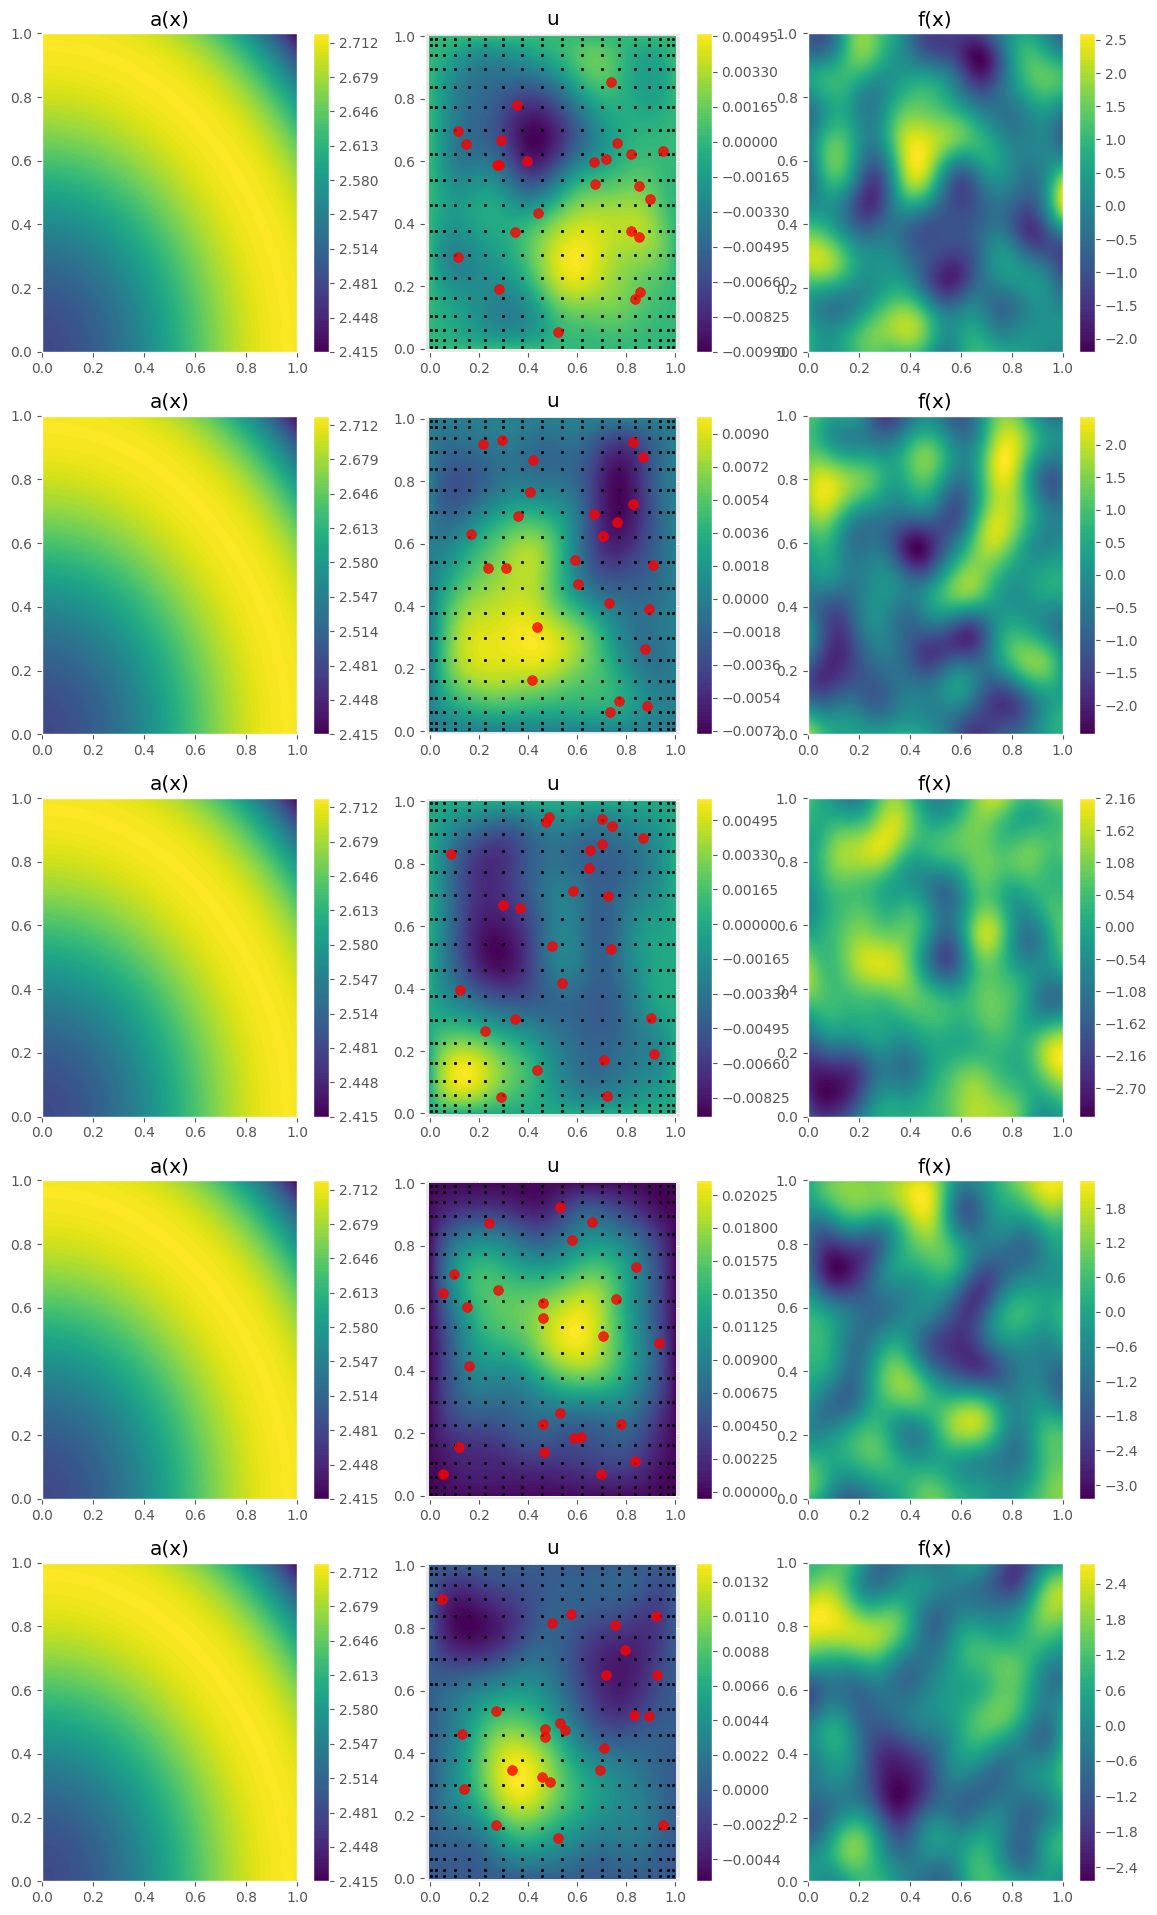

In [16]:
plt.figure(figsize=(14,4*num_functions+4))
for i in range(num_functions):
    plt.subplot(num_functions,3,3*i+1)
    plt.title('a(x)')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(a)(fine_grid),100)
    plt.colorbar()

    plt.subplot(num_functions,3,3*i+2)
    plt.title('u')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(u_true_functions[i])(fine_grid),100)
    plt.colorbar()
    plt.scatter(xy_int[:,0],xy_int[:,1],c = 'black',s = 3)
    plt.scatter(xy_obs[i][:,0],xy_obs[i][:,1],c = 'red',s = 50,alpha = 0.8)
    # plt.scatter(xy_bdy[:,0],xy_bdy[:,1],c = 'red',s = 50,alpha = 0.8)
    plt.xlim(-0.02,1.02)
    plt.ylim(-0.01,1.01)

    plt.subplot(num_functions,3,3*i+3)
    plt.title('f(x)')
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],jax.vmap(rhs_functions[i])(fine_grid),100)
    plt.colorbar()
    
plt.show()

In [37]:
def diff_x_op(k,index):
    return get_selected_grad(k,index,0)

def diff_xx_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,0)

def diff_y_op(k,index):
    return get_selected_grad(k,index,1)

def diff_yy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,1),index,1)

def diff_xy_op(k,index):
    return get_selected_grad(get_selected_grad(k,index,0),index,1)

feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])
basis_operators = feature_operators

k_u = get_gaussianRBF(0.25)
u_model = CholInducedRKHS(
    xy_all,
    basis_operators,
    k_u
)

observation_points = tuple(jnp.vstack([xy_bdy,obs]) for obs in xy_obs)
observation_values = tuple(jax.vmap(u)(obs_loc) for u,obs_loc in zip(u_true_functions,observation_points))
collocation_points = (xy_int,)*num_functions

rhs_values = tuple(jax.vmap(rhs_func)(int_points) for rhs_func,int_points in zip(rhs_functions,collocation_points))

all_u_params_init = tuple([
    u_model.get_fitted_params(obs_loc,obs_val) 
    for obs_loc,obs_val in zip(observation_points,observation_values)
    ]
    )

grid_features_u_init = [(
    u_model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
            len(xy_int),
            len(feature_operators),
            order = 'F'
        ) for model_params in all_u_params_init
        ]
grid_features_u_init = jnp.vstack([jnp.hstack([xy_int,features]) for features in grid_features_u_init])

num_P_inducing = 250
input_feature_sample = jax.random.choice(pkey(320),grid_features_u_init,(num_P_inducing,))
k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init[:,2:],c=1)
k_P_x_part = get_matern(2,0.25)

def k_P(x,y):
    return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

P_model = InducedOperatorModel(input_feature_sample,k_P)
P_init = P_model.get_fitted_params(grid_features_u_init,jnp.hstack(rhs_values),lam = 1e-4)

params_init = jnp.hstack(list(all_u_params_init)+[P_init])
u_init = jnp.stack(all_u_params_init)
EqnModel  = SharedOperatorPDEModel(
    P_model,
    u_model,
    observation_points,
    observation_values,
    collocation_points,
    feature_operators,
    rhs_values,
    datafit_weight = 10.,
    num_P_operator_params=num_P_inducing
)

In [38]:
beta_reg = 1e-8

from Optimizers import BlockArrowLM,LMParams
lm_params = LMParams(max_iter = 601,init_alpha = 1e-1,min_alpha = 1e-9)
u_sol,P_sol,arrow_conv = BlockArrowLM(
    u_init,P_init,EqnModel,beta_reg_u = 1e-12,beta_reg_P = 1e-2,
    optParams=lm_params
    )


  0%|          | 0/601 [00:00<?, ?it/s]

Iteration 0, loss = 1.325, gradnorm = 5.511, alpha = 0.08333, improvement_ratio = 0.9957
Iteration 1, loss = 1.058, gradnorm = 0.5991, alpha = 0.06944, improvement_ratio = 0.9993
Iteration 2, loss = 0.8117, gradnorm = 0.3274, alpha = 0.05787, improvement_ratio = 0.9994
Iteration 3, loss = 0.595, gradnorm = 0.3077, alpha = 0.04823, improvement_ratio = 0.9991
Iteration 4, loss = 0.414, gradnorm = 0.3238, alpha = 0.04019, improvement_ratio = 0.9984
Iteration 5, loss = 0.2723, gradnorm = 0.3475, alpha = 0.03349, improvement_ratio = 0.9967
Iteration 50, loss = 0.007975, gradnorm = 0.0007176, alpha = 9.157e-06, improvement_ratio = 1.004
Iteration 100, loss = 0.006737, gradnorm = 0.0004088, alpha = 1.006e-09, improvement_ratio = 1.004
Iteration 150, loss = 0.006152, gradnorm = 0.0003039, alpha = 8.333e-10, improvement_ratio = 1.002
Iteration 200, loss = 0.005784, gradnorm = 0.0002504, alpha = 8.333e-10, improvement_ratio = 1.002
Iteration 250, loss = 0.005525, gradnorm = 0.000212, alpha = 8.3

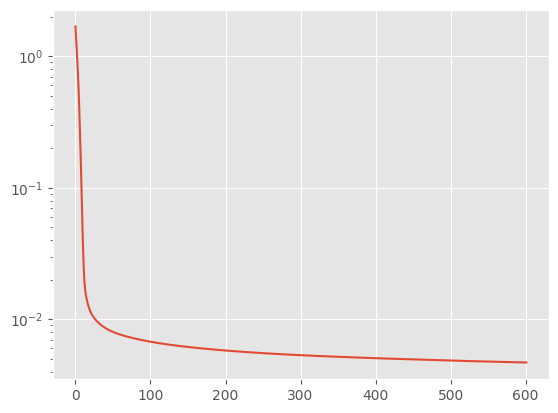

In [39]:
plt.plot(arrow_conv.loss_vals)
plt.yscale('log')

  0%|          | 0/5 [00:00<?, ?it/s]

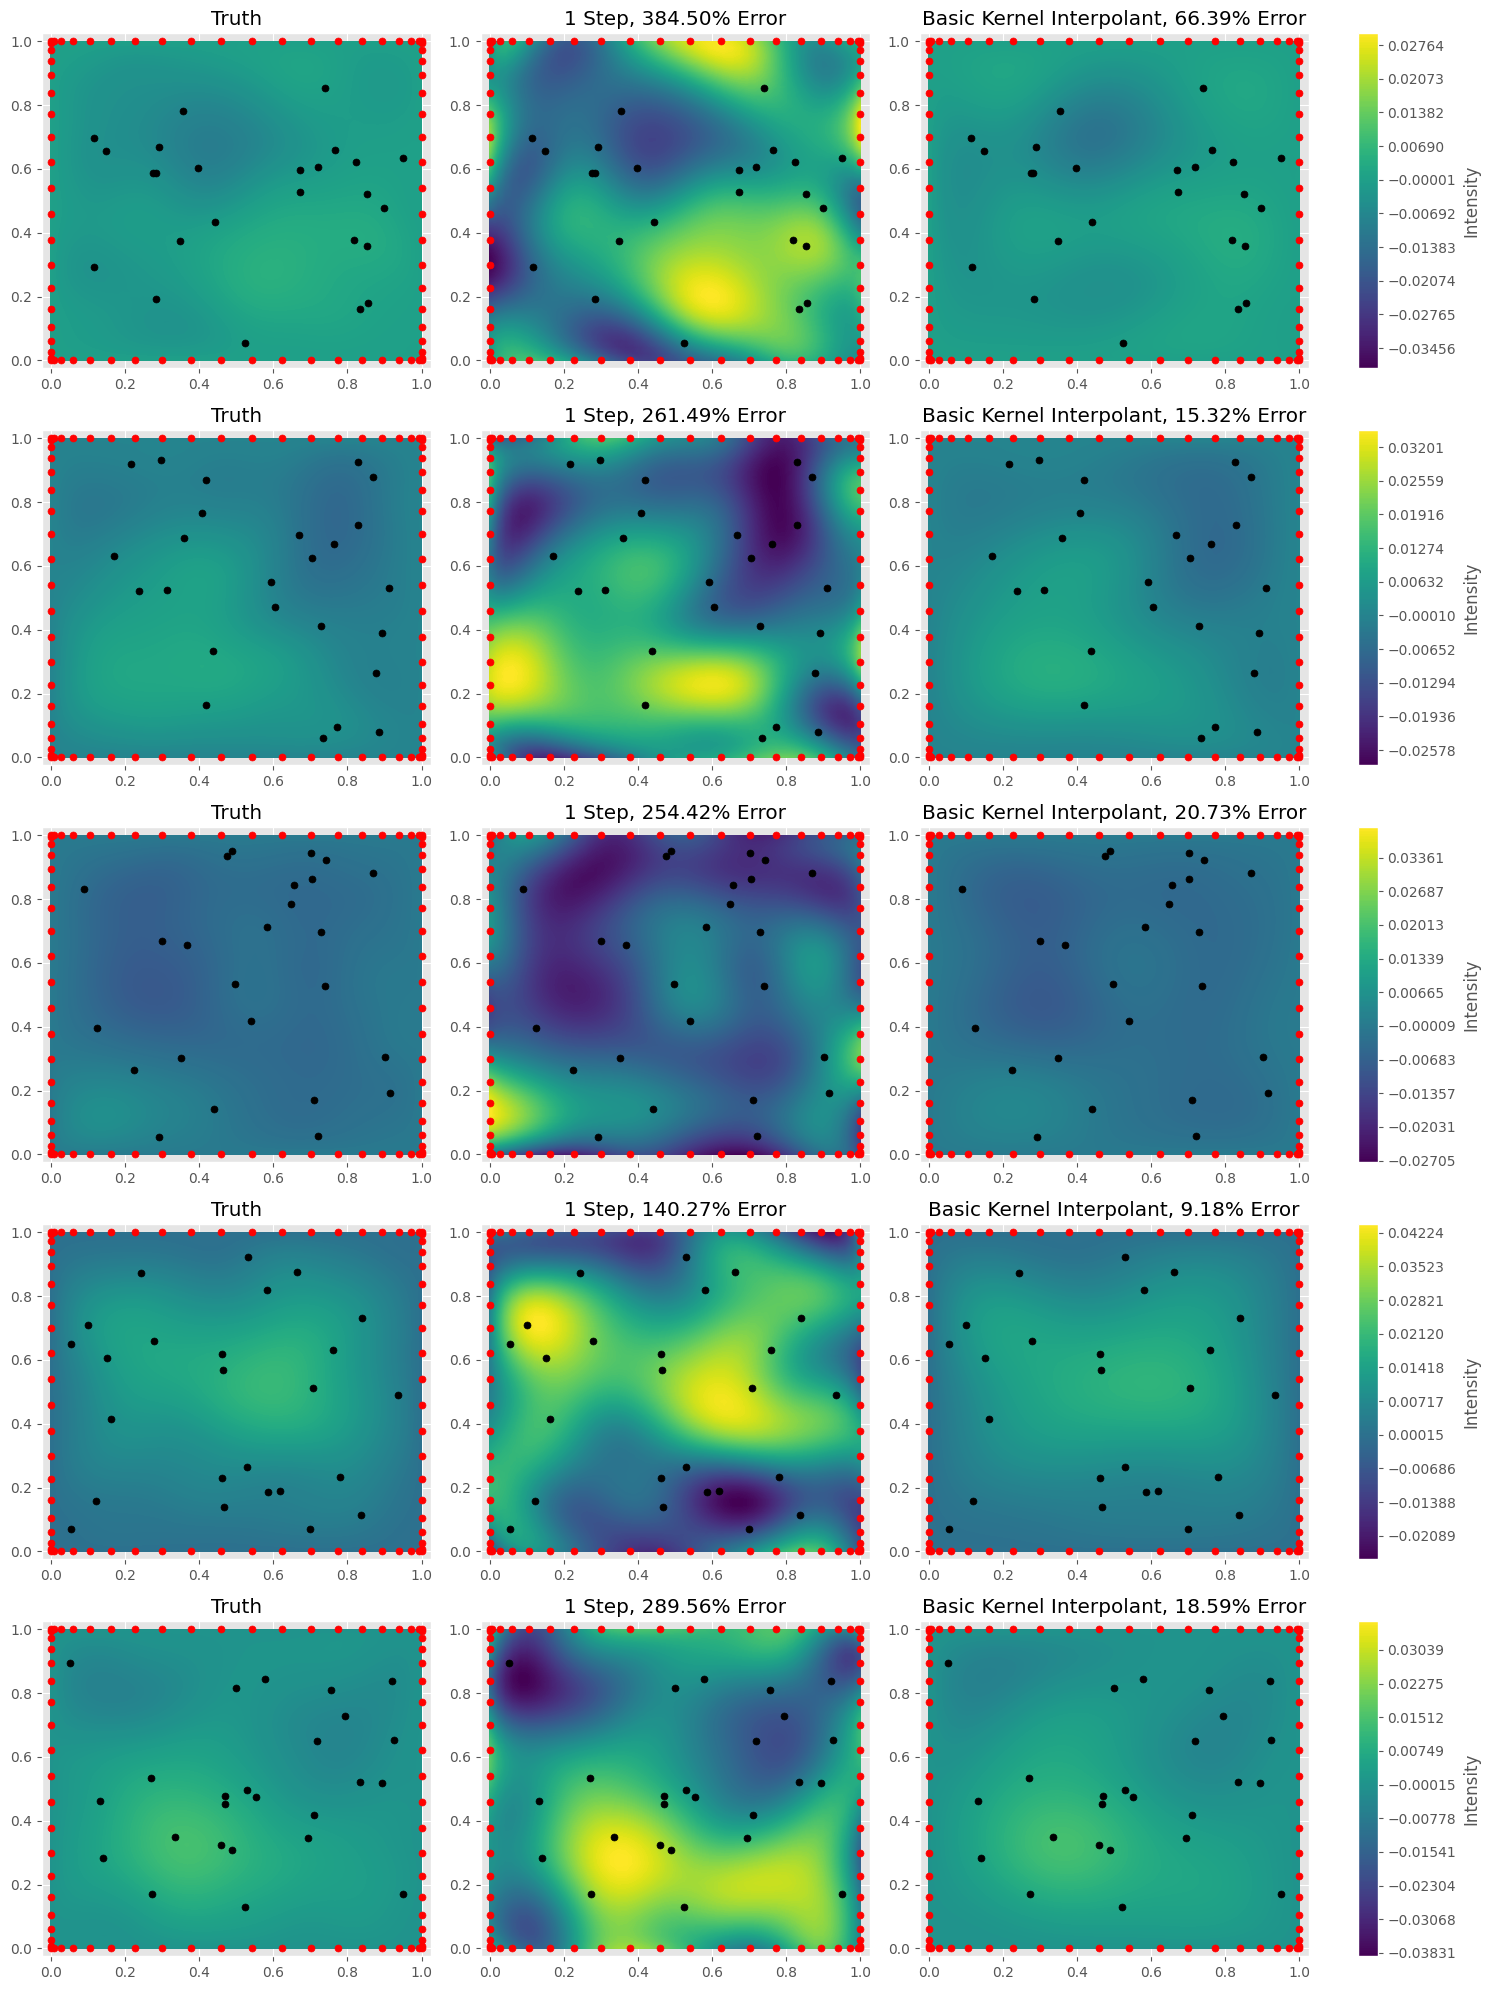

In [40]:
result_dict = {
    '1step_u_params':u_sol,
    '1step_P_params':P_sol,
    '2step_u_params':u_init,
    '2step_P_params':P_sol
               }


grid = jnp.linspace(0.,1.,50)
x,y = jnp.meshgrid(grid,grid)
fine_grid_int = jnp.vstack([x.flatten(),y.flatten()]).T

def get_percent_errors(u_params):
    #Have to loop since u_true_functions are just callables
    percent_errors = []
    for i in range(num_functions):
        u_vals = u_model.point_evaluate(fine_grid_int,u_params[i])
        u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)
        percent_errors.append(jnp.linalg.norm(u_vals - u_true_vals)/jnp.linalg.norm(u_true_vals))
    percent_errors = jnp.array(percent_errors)
    return percent_errors

onestep_errors = get_percent_errors(u_sol)
interp_errors = get_percent_errors(u_init)
result_dict['u_error_onestep'] = onestep_errors
result_dict['u_error_interp'] = interp_errors

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 4 * num_functions))
gs = gridspec.GridSpec(num_functions, 4, width_ratios=[1, 1, 1, 0.05])  # Last column for colorbar

for i in tqdm(range(num_functions)):
    # Get the subplots for this row
    ax1 = plt.subplot(gs[i, 0])
    ax2 = plt.subplot(gs[i, 1])
    ax3 = plt.subplot(gs[i, 2])
    cbar_ax = plt.subplot(gs[i, 3])  # Colorbar axis

    # Compute the values
    u_vals_1step = u_model.point_evaluate(fine_grid_int, u_sol[i])
    u_vals_interp = u_model.point_evaluate(fine_grid_int, u_init[i])
    u_true_vals = jax.vmap(u_true_functions[i])(fine_grid_int)

    # Determine the levels for consistent color mapping across subplots in the same row
    lower = jnp.min(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    upper = jnp.max(jnp.vstack([u_vals_1step, u_vals_interp, u_true_vals]))
    levels = jnp.linspace(lower, upper + 1e-4, 200)
    ax1.set_xlim(-0.025,1.025)
    ax1.set_ylim(-0.025,1.025)

    # First subplot: Truth
    ax1.set_title("Truth")
    contour_truth = ax1.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_true_vals, levels=levels)
    ax1.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax1.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)

    # Second subplot: 1 Step Solution
    ax2.set_title(f"1 Step, {100 * onestep_errors[i]:.2f}% Error")
    contour_1step = ax2.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_1step, levels=levels)
    ax2.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax2.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)
    ax2.set_xlim(-0.025,1.025)
    ax2.set_ylim(-0.025,1.025)

    # Third subplot: Basic Kernel Interpolant
    ax3.set_title(f"Basic Kernel Interpolant, {100 * interp_errors[i]:.2f}% Error")
    contour_interp = ax3.tricontourf(fine_grid_int[:, 0], fine_grid_int[:, 1], u_vals_interp, levels=levels)
    ax3.scatter(xy_obs[i][:, 0], xy_obs[i][:, 1], c='black', s=25)
    ax3.scatter(xy_bdy[:, 0], xy_bdy[:, 1], c='red', s=25)
    ax3.set_xlim(-0.025,1.025)
    ax3.set_ylim(-0.025,1.025)

    # Add colorbar for this row
    cbar = fig.colorbar(contour_interp, cax=cbar_ax)
    cbar_ax.set_ylabel('Intensity')  # Label for colorbar

# Adjust layout to prevent overlap
plt.tight_layout()

In [41]:
grid = jnp.linspace(0,1,40)
x,y = jnp.meshgrid(grid,grid)
fine_grid = jnp.vstack([x.flatten(),y.flatten()]).T


In [42]:

evaluation_key = pkey(10)
num_evaluation_functions = 10
kernel_f = get_gaussianRBF(0.15)
keys = jax.random.split(evaluation_key,num_evaluation_functions)

rhs_functions_eval = tuple(
    sample_gp_function(subkey,kernel_f) for subkey in keys
)
darcy_solve = get_darcy_solver(a,num_grid = 50,k_u = get_gaussianRBF(0.2))
u_true_eval = tuple([darcy_solve(f) for f in tqdm(rhs_functions_eval)])

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
index_to_eval = 8

true_feats = jnp.vstack([jax.vmap(op(u_true_eval[index_to_eval],0))(fine_grid) for op in feature_operators]).T
true_feats = jnp.hstack([fine_grid,true_feats])
in_sample_pred = P_model.predict(true_feats,P_sol)
truth = jax.vmap(rhs_functions_eval[index_to_eval])(fine_grid)

jnp.linalg.norm(in_sample_pred - truth)/jnp.linalg.norm(truth)

Array(0.83440732, dtype=float64)